Создаём абстрактные классы для унификации интерфейса между реализуемыми методами свёрточных слоёв и решением из torch, а также определяем некоторые функции:

In [1]:
import torch
from abc import ABC, abstractmethod

class ABCConv2d(ABC):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride

  def set_kernel(self, kernel):
    self.kernel = kernel

  @abstractmethod
  def __call__(self, input_tensor):
    pass

class TorchConv2d(ABCConv2d):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=0, bias=False)

  def set_kernel(self, kernel):
    self.conv2d.weight.data = kernel

  def __call__(self, input_tensor):
    return self.conv2d(input_tensor)



def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
  batch_size, channels_count, input_height, input_width = input_matrix_shape
  output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
  output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1
  return batch_size, out_channels, output_height, output_width

def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
  out_channels = kernel.shape[0]
  in_channels = kernel.shape[1]
  kernel_size = kernel.shape[2]

  layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
  layer.set_kernel(kernel)
  return layer(input_matrix)

def test_conv2d_layer(conv2d_layer_class, batch_size=2, input_height=5, input_width=5, stride=2):
    kernel = torch.tensor([[[[0., 1, 0], [1,  2, 1], [0,  1, 0]],
                            [[1, 2, 1], [0, 3, 3], [0, 1, 10]],
                            [[10, 11, 12], [13, 14, 15], [16, 17, 18]]],
                           
                           [[[1., 1, 5], [1,  2, 1], [10,  1, 0]],
                            [[1, 2, 1], [1, 3, 3], [7, 1, 10]],
                            [[10, 11, 12], [13, 14, 15], [16, 17, 18]]]])
    in_channels = kernel.shape[1]
    input_tensor = torch.arange(0, batch_size*in_channels*input_height*input_width, dtype=torch.float)
    input_tensor = input_tensor.reshape(batch_size, in_channels, input_height, input_width)

    my_conv2d = create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_tensor)
    torch_conv2d = create_and_call_conv2d_layer(TorchConv2d, stride, kernel, input_tensor)
    
    return torch.allclose(my_conv2d, torch_conv2d) and (my_conv2d.shape == torch_conv2d.shape)

Реализация свёртки с помощью циклов:

In [2]:
class Conv2dLoop(ABCConv2d):
    def __call__(self, input_tensor):
        output_tensor = torch.zeros(calc_out_shape(input_tensor.shape, self.out_channels, self.kernel_size, self.stride, 0))
        for image in range(output_tensor.shape[0]):
          for filter in range(output_tensor.shape[1]):
            for i in range(output_tensor.shape[2]):
              for j in range(output_tensor.shape[3]):
                  output_tensor[image, filter, i, j] += (input_tensor[image, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]*self.kernel[filter, :]).sum()
        return output_tensor

print(test_conv2d_layer(Conv2dLoop))

True


Реализация свёртки через матричное произведение (матричное представление ядра содержит лишние нули, что ухудшает производительность):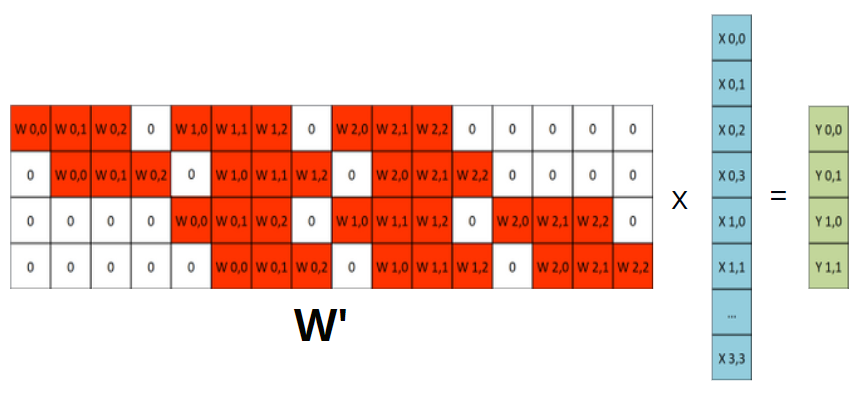

In [3]:
class Conv2dMatrix(ABCConv2d):
    def _unsqueeze_kernel(self, torch_input, output_height, output_width):
        in_pix, out_pix = torch_input.reshape(torch_input.shape[0], torch_input.shape[1], -1).shape[2], output_height*output_width
        n_fl, n_ch = self.kernel.shape[0], torch_input.shape[1]
        kernel_unsqueezed = torch.zeros(out_pix*n_fl, in_pix*n_ch)
        data_w = torch_input.shape[3]
        for filter in range(n_fl):
          for chanel in range(n_ch):
            for i in range(filter*out_pix, (filter+1)*out_pix):
              for j in range(self.kernel_size):
                x = chanel*in_pix + j*data_w + (i%output_width + i//output_width*data_w)*self.stride - filter*data_w*output_height*self.stride
                kernel_unsqueezed[i, x:x+self.kernel_size] = self.kernel[filter, chanel, j]
        return kernel_unsqueezed

    def __call__(self, torch_input):
        batch_size, out_channels, output_height, output_width = calc_out_shape(torch_input.shape,
                                                                               self.kernel.shape[0],
                                                                               self.kernel.shape[2],
                                                                               self.stride, 0)

        kernel_unsqueezed = self._unsqueeze_kernel(torch_input, output_height, output_width)
        result = kernel_unsqueezed @ torch_input.view((batch_size, -1)).permute(1, 0)
        return result.permute(1, 0).view((batch_size, self.out_channels, output_height, output_width))

print(test_conv2d_layer(Conv2dMatrix))

True


Альтернативная реализация свёртки через матричное произведение (без лишних нулей в матрицах):

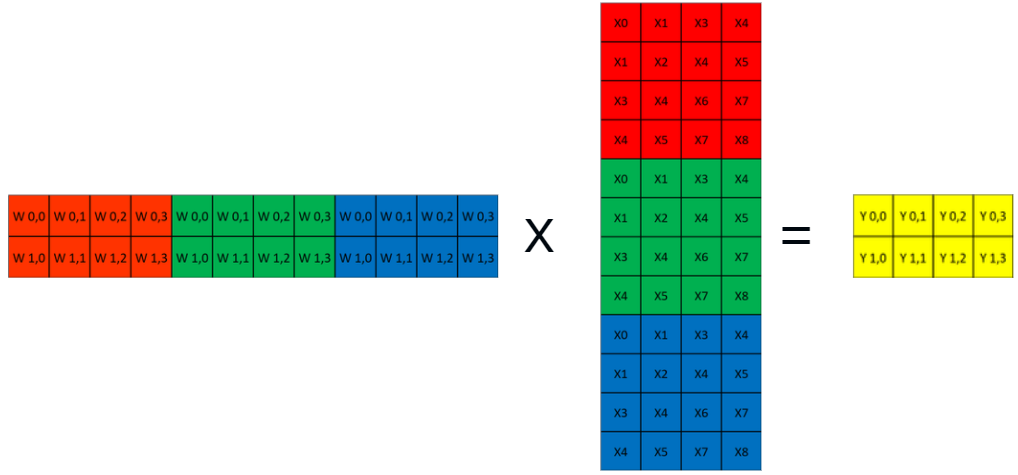

In [4]:
class Conv2dMatrixV2(ABCConv2d):
    def _convert_kernel(self):
        converted_kernel = self.kernel.reshape(self.kernel.shape[0], -1)
        return converted_kernel

    def _convert_input(self, torch_input, output_height, output_width):
        out_pix = output_height*output_width
        converted_input = torch.zeros(self.kernel_size**2*self.in_channels, out_pix*torch_input.shape[0])
        for image in range(torch_input.shape[0]):
          for chanel in range(self.in_channels):
            for i in range(output_height):
              for j in range(output_width):
                y, x = i*self.stride, j*self.stride
                y_in, x_in = chanel*self.kernel_size**2, image*out_pix+j+i*output_width
                converted_input[y_in:y_in+self.kernel_size**2, x_in] = torch_input[image, chanel, y:y+self.kernel_size, x:x+self.kernel_size].reshape(1, -1)
        return converted_input

    def __call__(self, torch_input):
        batch_size, out_channels, output_height, output_width = calc_out_shape(torch_input.shape,
                                                                               self.kernel.shape[0],
                                                                               self.kernel.shape[2],
                                                                               self.stride, 0)

        converted_kernel = self._convert_kernel()
        converted_input = self._convert_input(torch_input, output_height, output_width)

        conv2d_out = converted_kernel @ converted_input
        conv2d_out = conv2d_out.reshape(conv2d_out.shape[0], torch_input.shape[0], -1).transpose(1, 0)
        conv2d_out = conv2d_out.reshape(torch_input.shape[0], self.out_channels, output_height, output_width)
        return conv2d_out

print(test_conv2d_layer(Conv2dMatrixV2))

True
